# Case Study 3 - Multiple Runs

# 0 - Defining Basic Functionalities

In [37]:
import pandas as pd
import numpy as np
import uci_dataset as database
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import raimitigations.dataprocessing as dp

N_EXEC = 50

USE_AUC_TH = False

RESULT_KEYS = ["roc", "pr", "rc", "f1"]
COL_METRIC = "Metric"
COL_VALUE = "Value"
COL_TEST = "Test Case"

SEQ_FWD = 0
SEQ_BWD = 1
CATBOOST = 2

# -----------------------------------
def encode_case3(df):
	enc_ohe = dp.EncoderOHE(verbose=False)
	enc_ohe.fit(df)
	proc_df = enc_ohe.transform(df)
	return proc_df


# -----------------------------------
def encode_case3_train_test(train_x, test_x):
	enc_ohe = dp.EncoderOHE(drop=False, unknown_err=False, verbose=False)
	enc_ohe.fit(train_x)
	train_x_enc = enc_ohe.transform(train_x)
	test_x_enc = enc_ohe.transform(test_x)
	return train_x_enc, test_x_enc


# -----------------------------------
def impute_case3(df):
	imputer = dp.BasicImputer(	numerical={	'missing_values':np.nan,
											'strategy':'constant',
											'fill_value':-1},
								verbose=False)
	imputer.fit(df)
	proc_df = imputer.transform(df)
	return proc_df


# -----------------------------------
def impute_case3_train_test(train_x, test_x):
	imputer = dp.BasicImputer(	numerical={	'missing_values':np.nan,
											'strategy':'constant',
											'fill_value':-1},
								verbose=False)
	imputer.fit(train_x)
	train_x_enc = imputer.transform(train_x)
	test_x_enc = imputer.transform(test_x)
	return train_x_enc, test_x_enc


# -----------------------------------
def remove_corr_feat(df, label_col):
	cor_feat = dp.CorrelatedFeatures(
					method_num_num=["spearman", "pearson", "kendall"],				# Used for Numerical x Numerical correlations
					num_corr_th=0.9,												# Used for Numerical x Numerical correlations
					num_pvalue_th=0.05,												# Used for Numerical x Numerical correlations
					method_num_cat="model",											# Used for Numerical x Categorical correlations
					model_metrics=["f1", "auc"],									# Used for Numerical x Categorical correlations
					metric_th=0.9,													# Used for Numerical x Categorical correlations
					cat_corr_th=0.9,												# Used for Categorical x Categorical correlations
					cat_pvalue_th=0.01,												# Used for Categorical x Categorical correlations
					save_json=False,
					verbose=False
				)
	cor_feat.fit(df=df, label_col=label_col)
	proc_df = cor_feat.transform(df)
	return proc_df


# -----------------------------------
def transform_num_data(train_x, test_x, scaler_ref, num_col):
	ignore = None
	if num_col is not None:
		ignore = [col for col in train_x.columns if col not in num_col]
	transformer = scaler_ref(exclude_cols=ignore, verbose=False)
	transformer.fit(train_x)
	train_x_scl = transformer.transform(train_x)
	test_x_scl = transformer.transform(test_x)
	return train_x_scl, test_x_scl

# -----------------------------------
def feature_selection(train_x, train_y, test_x, feat_sel_type):
	if feat_sel_type == SEQ_FWD:
		feat_sel = dp.SeqFeatSelection(forward=True, n_jobs=4, verbose=False)
	elif feat_sel_type == SEQ_BWD:
		feat_sel = dp.SeqFeatSelection(forward=False, n_jobs=4, verbose=False)
	else:
		feat_sel = dp.CatBoostSelection(verbose=False)
	feat_sel.fit(X=train_x, y=train_y)
	train_x_sel = feat_sel.transform(train_x)
	test_x_sel = feat_sel.transform(test_x)

	features = feat_sel.get_selected_features()
	return train_x_sel, test_x_sel

# -----------------------------------
def artificial_smote(train_x, train_y, strategy, under_sample):
	rebalance = dp.Rebalance(
				X=train_x,
				y=train_y,
				strategy_over=strategy,
				over_sampler=True,
				under_sampler=under_sample,
				verbose=False
			)
	train_x_res, train_y_res = rebalance.fit_resample()
	return train_x_res, train_y_res

# -----------------------------------
def artificial_ctgan(train_x, train_y, strategy, savefile):
	synth = dp.Synthesizer(
				X=train_x,
				y=train_y,
				epochs=1000,
				model="ctgan",
				load_existing=True,
				save_file=savefile,
				verbose=False
			)
	synth.fit()
	syn_train_x, syn_train_y = synth.transform(X=train_x, y=train_y, strategy=strategy)
	return syn_train_x, syn_train_y

# -----------------------------------
# -----------------------------------
# -----------------------------------
def result_statistics(result_list):
	result_stat = {}
	for result in result_list:
		for key in RESULT_KEYS:
			if key in result_stat.keys():
				result_stat[key].append(result[key])
			else:
				result_stat[key] = [result[key]]
	
	#for key in RESULT_KEYS:
	#	mean = np.mean(result_stat[key])
	#	std = np.std(result_stat[key])
	#	result_stat[key] = {'mean':mean, 'std':std}

	return result_stat


# -----------------------------------
def add_results_df(result_df, result_stat, test_name):
	col_test = []
	col_metric = []
	col_value = []
	for metric in RESULT_KEYS:
		col_value += result_stat[metric]
		col_test += [test_name for _ in range(len(result_stat[metric]))]
		col_metric += [metric for _ in range(len(result_stat[metric]))]

	new_df = pd.DataFrame()
	new_df[COL_VALUE] = col_value
	new_df[COL_TEST] = col_test
	new_df[COL_METRIC] = col_metric
	new_df[COL_VALUE] = new_df[COL_VALUE].apply(float)

	if result_df is None:
		return new_df
	
	result_df = pd.concat([result_df, new_df], axis=0)
	
	return result_df


# -----------------------------------
def test_base(df, label_col, n_exec, model_name):
	result_list = []
	proc_df = encode_case3(df)
	proc_df = impute_case3(proc_df)
	for n in range(n_exec):
		train_x, test_x, train_y, test_y = dp.split_data(proc_df, label_col, test_size=0.25)
		result = dp.train_model_fetch_results(train_x, train_y, test_x, test_y, model_name, USE_AUC_TH)
		result_list.append(result)

	result_stat = result_statistics(result_list)

	return result_stat


# -----------------------------------
def test_corr(df, label_col, n_exec, model_name):
	result_list = []
	proc_df = remove_corr_feat(df, label_col)
	proc_df = encode_case3(proc_df)
	proc_df = impute_case3(proc_df)
	for n in range(n_exec):
		train_x, test_x, train_y, test_y = dp.split_data(proc_df, label_col, test_size=0.25)
		result = dp.train_model_fetch_results(train_x, train_y, test_x, test_y, model_name, USE_AUC_TH)
		result_list.append(result)

	result_stat = result_statistics(result_list)

	return result_stat


# -----------------------------------
def test_corr_transf(df, label_col, n_exec, scaler_ref, model_name, num_col=None):
	result_list = []
	proc_df = remove_corr_feat(df, label_col)
	proc_df = encode_case3(proc_df)
	proc_df = impute_case3(proc_df)
	for n in range(n_exec):
		train_x, test_x, train_y, test_y = dp.split_data(proc_df, label_col, test_size=0.25)
		train_x, test_x = transform_num_data(train_x, test_x, scaler_ref, num_col)
		result = dp.train_model_fetch_results(train_x, train_y, test_x, test_y, model_name, USE_AUC_TH)
		result_list.append(result)

	result_stat = result_statistics(result_list)

	return result_stat

# -----------------------------------
def test_smote_transf(df, label_col, n_exec, model_name, rcorr=True, scaler_ref=None, num_col=None, feat_sel_type=None, art_str=None, under=False):
	result_list = []
	proc_df = df
	if rcorr:
		proc_df = remove_corr_feat(proc_df, label_col)
	proc_df = encode_case3(proc_df)
	proc_df = impute_case3(proc_df)
	for n in range(n_exec):
		train_x, test_x, train_y, test_y = dp.split_data(proc_df, label_col, test_size=0.25)
		if art_str is not None:
			train_x, train_y = artificial_smote(train_x, train_y, art_str, under)
		if feat_sel_type is not None:
			train_x, test_x = feature_selection(train_x, train_y, test_x, feat_sel_type)
		if scaler_ref is not None:
			train_x, test_x = transform_num_data(train_x, test_x, scaler_ref, num_col)
		result = dp.train_model_fetch_results(train_x, train_y, test_x, test_y, model_name, USE_AUC_TH)
		result_list.append(result)

	result_stat = result_statistics(result_list)

	return result_stat



# -----------------------------------
def test_ctgan_first(df, label_col, n_exec, model_name, rcorr=True, scaler_ref=None, num_col=None, feat_sel_type=None, art_str=None, savefile=None):
	result_list = []
	proc_df = df
	if rcorr:
		proc_df = remove_corr_feat(proc_df, label_col)
	for n in range(n_exec):
		train_x, test_x, train_y, test_y = dp.split_data(proc_df, label_col, test_size=0.25)
		if art_str is not None:
			train_x, train_y = artificial_ctgan(train_x, train_y, art_str, savefile)
		train_x, test_x = encode_case3_train_test(train_x, test_x)
		train_x, test_x = impute_case3_train_test(train_x, test_x)
		if feat_sel_type is not None:
			train_x, test_x = feature_selection(train_x, train_y, test_x, feat_sel_type)
		if scaler_ref is not None:
			train_x, test_x = transform_num_data(train_x, test_x, scaler_ref, num_col)
		result = dp.train_model_fetch_results(train_x, train_y, test_x, test_y, model_name, USE_AUC_TH)
		result_list.append(result)

	result_stat = result_statistics(result_list)

	return result_stat

# -----------------------------------
# -----------------------------------
# -----------------------------------
def plot_results(res_df, y_lim=[0.5, 1.0]):
	plt.figure().clear()
	plt.close()
	plt.cla()
	plt.clf()

	fig = plt.gcf()
	fig.set_size_inches(18, 10)
	#fig.set_dpi(100)

	sns.set_theme(style="whitegrid")
	plt.ylim(y_lim[0], y_lim[1])
	ax = sns.barplot(x=COL_METRIC, y=COL_VALUE, hue=COL_TEST, data=res_df)
	plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=20)
	#ax.axes.set_title("Title",fontsize=50)
	ax.set_xlabel(COL_METRIC, fontsize=30)
	ax.set_ylabel(COL_VALUE, fontsize=30)
	ax.tick_params(labelsize=15)
	plt.show()

# 1 - Understanding the Data

In [2]:
df = database.load_thyroid_disease()
label_col = "sick-euthyroid"
df[label_col] = df[label_col].replace({"sick-euthyroid": 1, "negative": 0})
df

,sick-euthyroid,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,thyroid_surgery,query_hypothyroid,query_hyperthyroid,pregnant,...,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG
0,1,72.0,M,f,f,f,f,f,f,f,...,y,1.0,y,83.0,y,0.95,y,87.0,n,NaN
1,1,45.0,F,f,f,f,f,f,f,f,...,y,1.0,y,82.0,y,0.73,y,112.0,n,NaN
2,1,64.0,F,f,f,f,f,f,f,f,...,y,1.0,y,101.0,y,0.82,y,123.0,n,NaN
3,1,56.0,M,f,f,f,f,f,f,f,...,y,0.8,y,76.0,y,0.77,y,99.0,n,NaN
4,1,78.0,F,t,f,f,f,t,f,f,...,y,0.3,y,87.0,y,0.95,y,91.0,n,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3158,0,40.0,F,f,f,f,f,f,f,f,...,y,1.2,y,76.0,y,0.90,y,84.0,n,NaN
3159,0,69.0,F,f,f,f,f,f,f,f,...,y,1.8,y,126.0,y,1.02,y,124.0,n,NaN
3160,0,58.0,F,f,f,f,f,f,f,f,...,y,1.7,y,86.0,y,0.91,y,95.0,n,NaN
3161,0,29.0,F,f,f,f,f,f,f,f,...,y,1.8,y,99.0,y,1.01,y,98.0,n,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3163 entries, 0 to 3162
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   sick-euthyroid             3163 non-null   int64  
 1   age                        2717 non-null   float64
 2   sex                        3090 non-null   object 
 3   on_thyroxine               3163 non-null   object 
 4   query_on_thyroxine         3163 non-null   object 
 5   on_antithyroid_medication  3163 non-null   object 
 6   thyroid_surgery            3163 non-null   object 
 7   query_hypothyroid          3163 non-null   object 
 8   query_hyperthyroid         3163 non-null   object 
 9   pregnant                   3163 non-null   object 
 10  sick                       3163 non-null   object 
 11  tumor                      3163 non-null   object 
 12  lithium                    3163 non-null   object 
 13  goitre                     3163 non-null   objec

In [4]:
num_col = ['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI', 'TBG']

# 2 - Efficiency of Different Classes from raimitigations.dataprocessing lib

## KNN Model

### Data Transformations

In [5]:
MODEL_NAME = "knn"

result_base = test_base(df, label_col, N_EXEC, MODEL_NAME)
result_df = add_results_df(None, result_base, "Baseline")

result_cor = test_corr(df, label_col, N_EXEC, MODEL_NAME)
result_df = add_results_df(result_df, result_cor, "Corr.")

result_tr = test_corr_transf(df, label_col, N_EXEC, dp.DataStandardScaler, MODEL_NAME, num_col)
result_df = add_results_df(result_df, result_tr, "Std.")

result_tr = test_corr_transf(df, label_col, N_EXEC, dp.DataMinMaxScaler, MODEL_NAME, num_col)
result_df = add_results_df(result_df, result_tr, "Min/Max.")

result_tr = test_corr_transf(df, label_col, N_EXEC, dp.DataQuantileTransformer, MODEL_NAME, num_col)
result_df = add_results_df(result_df, result_tr, "Quantile")

result_tr = test_corr_transf(df, label_col, N_EXEC, dp.DataNormalizer, MODEL_NAME, num_col)
result_df = add_results_df(result_df, result_tr, "Normalizer")

result_tr = test_corr_transf(df, label_col, N_EXEC, dp.DataRobustScaler, MODEL_NAME, num_col)
result_df = add_results_df(result_df, result_tr, "Robust")

result_tr = test_corr_transf(df, label_col, N_EXEC, dp.DataPowerTransformer, MODEL_NAME, num_col)
result_df = add_results_df(result_df, result_tr, "Power")

../../errorsmitigation/dataprocessing/utils_model.py:65: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
../../errorsmitigation/dataprocessing/utils_model.py:65: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
../../errorsmitigation/dataprocessing/utils_model.py:65: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
../../errorsmitigation/dataprocessing/utils_model.py:65: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
../../errorsmitigation/dataprocessing/utils_model.py:65: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
../../errorsmitigation/dataprocessing/utils_model.py:65: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * preci

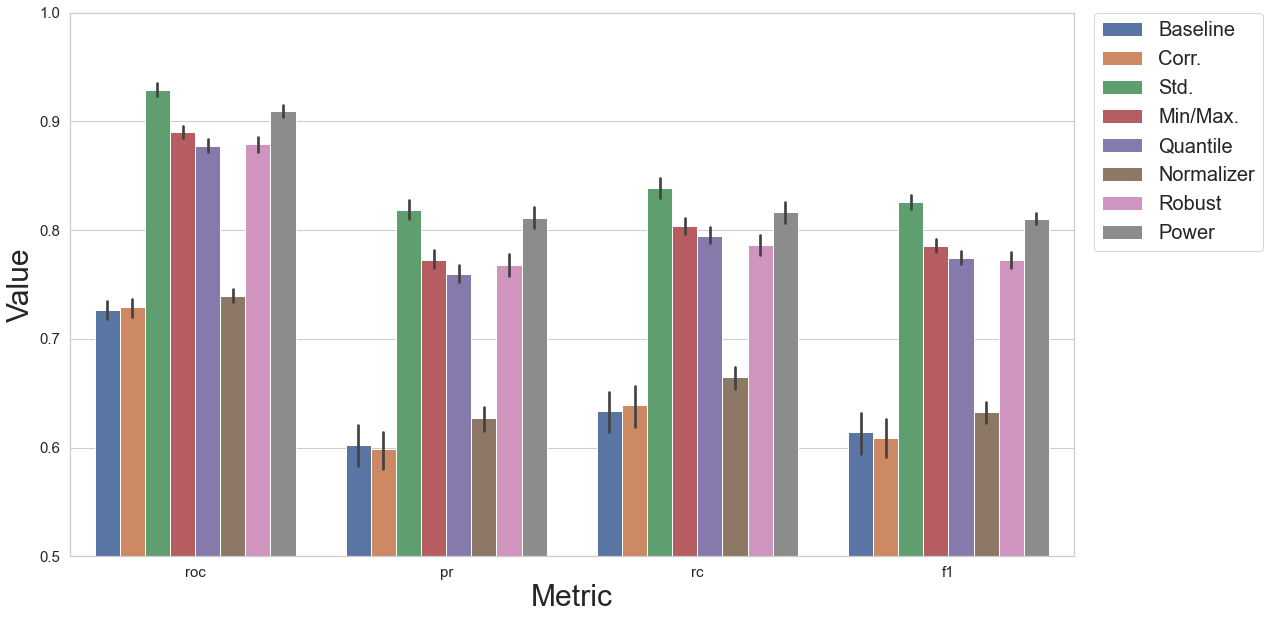

In [6]:
plot_results(result_df)

### Sequential Feature Selection - Forward

In [7]:
result_base = test_base(df, label_col, N_EXEC, MODEL_NAME)
result_df = add_results_df(None, result_base, "Baseline")

result_tr = test_corr_transf(df, label_col, N_EXEC, dp.DataStandardScaler, MODEL_NAME, num_col)
result_df = add_results_df(result_df, result_tr, "Std.")

restult_fs = test_smote_transf(df, label_col, N_EXEC, MODEL_NAME, rcorr=False, scaler_ref=None, feat_sel_type=SEQ_FWD)
result_df = add_results_df(result_df, restult_fs, "Seq. Fwd.")

restult_fs = test_smote_transf(df, label_col, N_EXEC, MODEL_NAME, rcorr=True, scaler_ref=None, feat_sel_type=SEQ_FWD)
result_df = add_results_df(result_df, restult_fs, "Corr.Seq.Fwd")

restult_fs = test_smote_transf(df, label_col, N_EXEC, MODEL_NAME, rcorr=True, scaler_ref=dp.DataStandardScaler, num_col=num_col, feat_sel_type=SEQ_FWD)
result_df = add_results_df(result_df, restult_fs, "Corr.Seq.Fwd.Std.")

../../errorsmitigation/dataprocessing/utils_model.py:65: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
../../errorsmitigation/dataprocessing/utils_model.py:65: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
../../errorsmitigation/dataprocessing/utils_model.py:65: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
../../errorsmitigation/dataprocessing/utils_model.py:65: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
../../errorsmitigation/dataprocessing/utils_model.py:65: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
../../errorsmitigation/dataprocessing/utils_model.py:65: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * preci

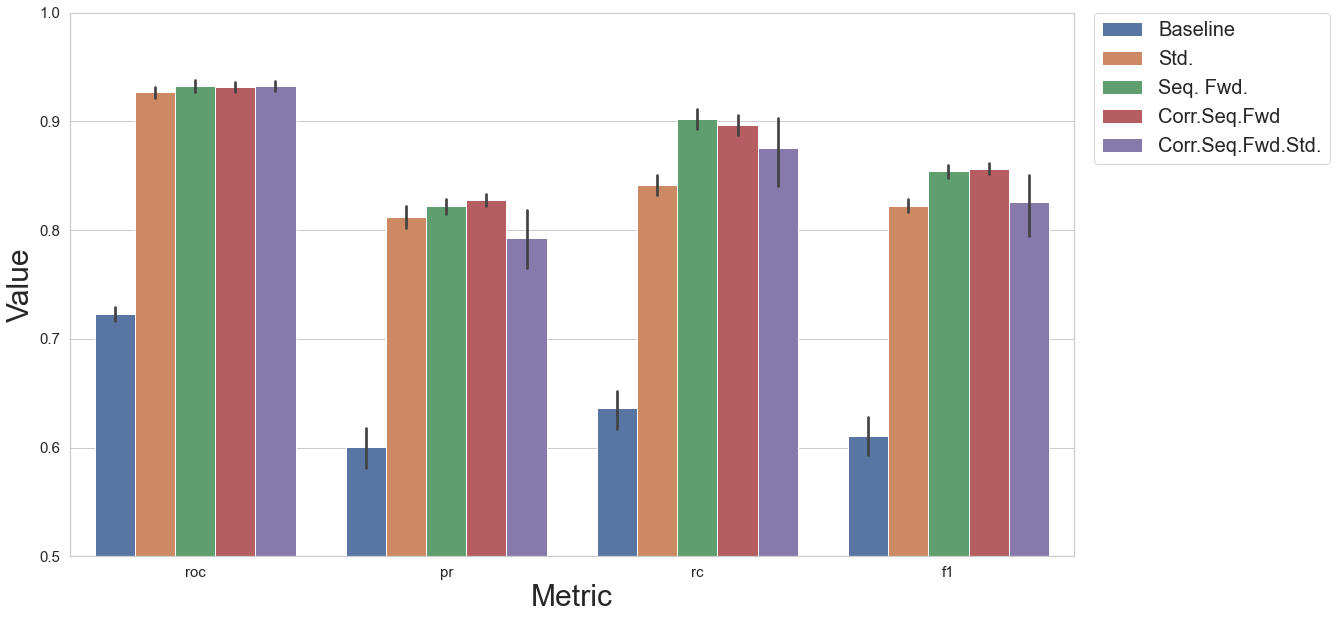

In [8]:
plot_results(result_df)

### Sequential Feature Selection - Forward x Backward x CatBoost Feature Selection

In [9]:
result_base = test_base(df, label_col, N_EXEC, MODEL_NAME)
result_df = add_results_df(None, result_base, "Baseline")

restult_fs = test_smote_transf(df, label_col, N_EXEC, MODEL_NAME, rcorr=False, scaler_ref=None, feat_sel_type=SEQ_FWD)
result_df = add_results_df(result_df, restult_fs, "Seq. Fwd.")

restult_fs = test_smote_transf(df, label_col, N_EXEC, MODEL_NAME, rcorr=False, scaler_ref=None, feat_sel_type=SEQ_BWD)
result_df = add_results_df(result_df, restult_fs, "Seq. Bwd.")

restult_fs = test_smote_transf(df, label_col, N_EXEC, MODEL_NAME, rcorr=False, scaler_ref=dp.DataStandardScaler, num_col=num_col, feat_sel_type=SEQ_BWD)
result_df = add_results_df(result_df, restult_fs, "Seq.Bwd.Std.")

restult_fs = test_smote_transf(df, label_col, N_EXEC, MODEL_NAME, rcorr=False, scaler_ref=dp.DataStandardScaler, num_col=num_col, feat_sel_type=CATBOOST)
result_df = add_results_df(result_df, restult_fs, "CatBoost Std.")

../../errorsmitigation/dataprocessing/utils_model.py:65: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
../../errorsmitigation/dataprocessing/utils_model.py:65: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
../../errorsmitigation/dataprocessing/utils_model.py:65: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
../../errorsmitigation/dataprocessing/utils_model.py:65: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
../../errorsmitigation/dataprocessing/utils_model.py:65: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
../../errorsmitigation/dataprocessing/utils_model.py:65: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * preci

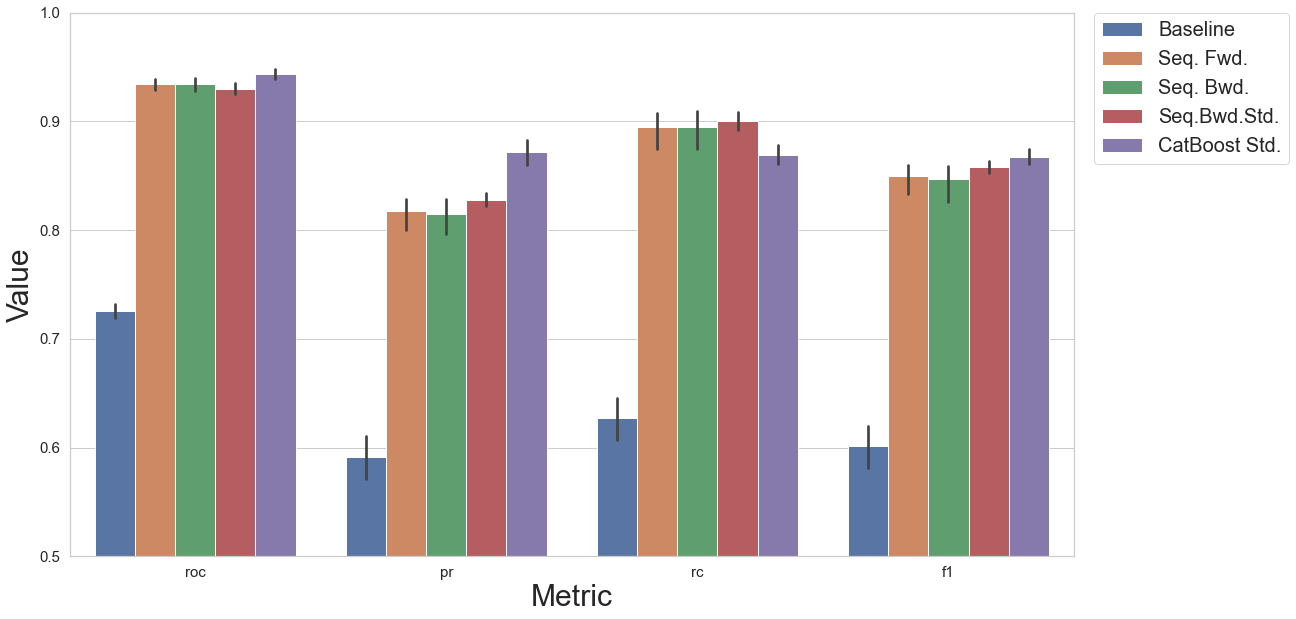

In [10]:
plot_results(result_df)

### Artificial Instances - SMOTE

In [11]:
result_base = test_base(df, label_col, N_EXEC, MODEL_NAME)
result_df = add_results_df(None, result_base, "Baseline")

result_tr = test_corr_transf(df, label_col, N_EXEC, dp.DataStandardScaler, MODEL_NAME, num_col)
result_df = add_results_df(result_df, result_tr, "Std.")

restult_fs = test_smote_transf(df, label_col, N_EXEC, MODEL_NAME, rcorr=True, scaler_ref=None, feat_sel_type=None, art_str=0.2, under=False)
result_df = add_results_df(result_df, restult_fs, "SM")

restult_fs = test_smote_transf(df, label_col, N_EXEC, MODEL_NAME, rcorr=True, scaler_ref=dp.DataStandardScaler, feat_sel_type=None, art_str=0.2, under=False)
result_df = add_results_df(result_df, restult_fs, "SM Std.")

restult_fs = test_smote_transf(df, label_col, N_EXEC, MODEL_NAME, rcorr=True, scaler_ref=None, feat_sel_type=None, art_str=0.2, under=True)
result_df = add_results_df(result_df, restult_fs, "SM+TK")

restult_fs = test_smote_transf(df, label_col, N_EXEC, MODEL_NAME, rcorr=True, scaler_ref=dp.DataStandardScaler, feat_sel_type=None, art_str=0.2, under=True)
result_df = add_results_df(result_df, restult_fs, "SM+TK Std.")

../../errorsmitigation/dataprocessing/utils_model.py:65: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
../../errorsmitigation/dataprocessing/utils_model.py:65: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
../../errorsmitigation/dataprocessing/utils_model.py:65: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
../../errorsmitigation/dataprocessing/utils_model.py:65: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


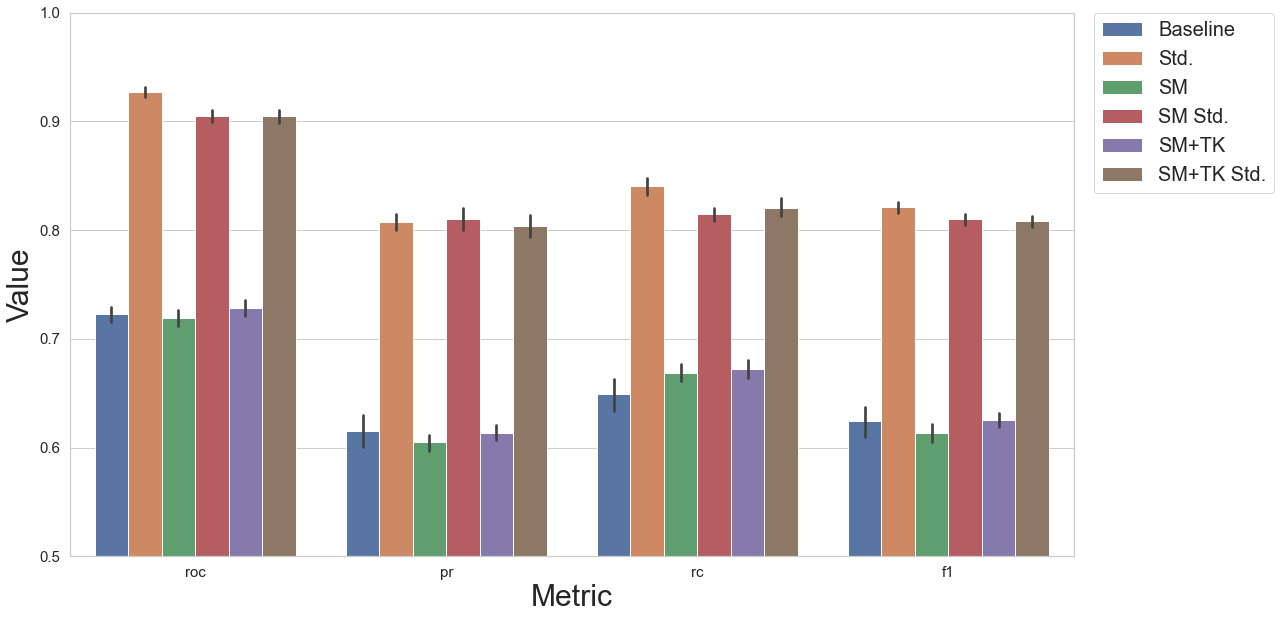

In [12]:
plot_results(result_df)

### Artificial Instances - CTGAN

In [39]:
MODEL_NAME = "knn"
result_base = test_base(df, label_col, N_EXEC, MODEL_NAME)
result_df = add_results_df(None, result_base, "Baseline")

result_tr = test_corr_transf(df, label_col, N_EXEC, dp.DataStandardScaler, MODEL_NAME, num_col)
result_df = add_results_df(result_df, result_tr, "Std.")

restult_fs = test_ctgan_first(df, label_col, N_EXEC, MODEL_NAME, rcorr=True, scaler_ref=dp.DataStandardScaler, feat_sel_type=None, art_str=0.2, savefile="3_1.pkl")
result_df = add_results_df(result_df, restult_fs, "CTGAN 0.2 Std.")

restult_fs = test_ctgan_first(df, label_col, N_EXEC, MODEL_NAME, rcorr=True, scaler_ref=dp.DataStandardScaler, feat_sel_type=None, art_str=0.6, savefile="3_2.pkl")
result_df = add_results_df(result_df, restult_fs, "CTGAN 0.6 Std.")


../../errorsmitigation/dataprocessing/utils_model.py:65: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
../../errorsmitigation/dataprocessing/utils_model.py:65: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
../../errorsmitigation/dataprocessing/utils_model.py:65: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
../../errorsmitigation/dataprocessing/utils_model.py:65: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
../../errorsmitigation/dataprocessing/utils_model.py:65: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
../../errorsmitigation/dataprocessing/utils_model.py:65: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * preci

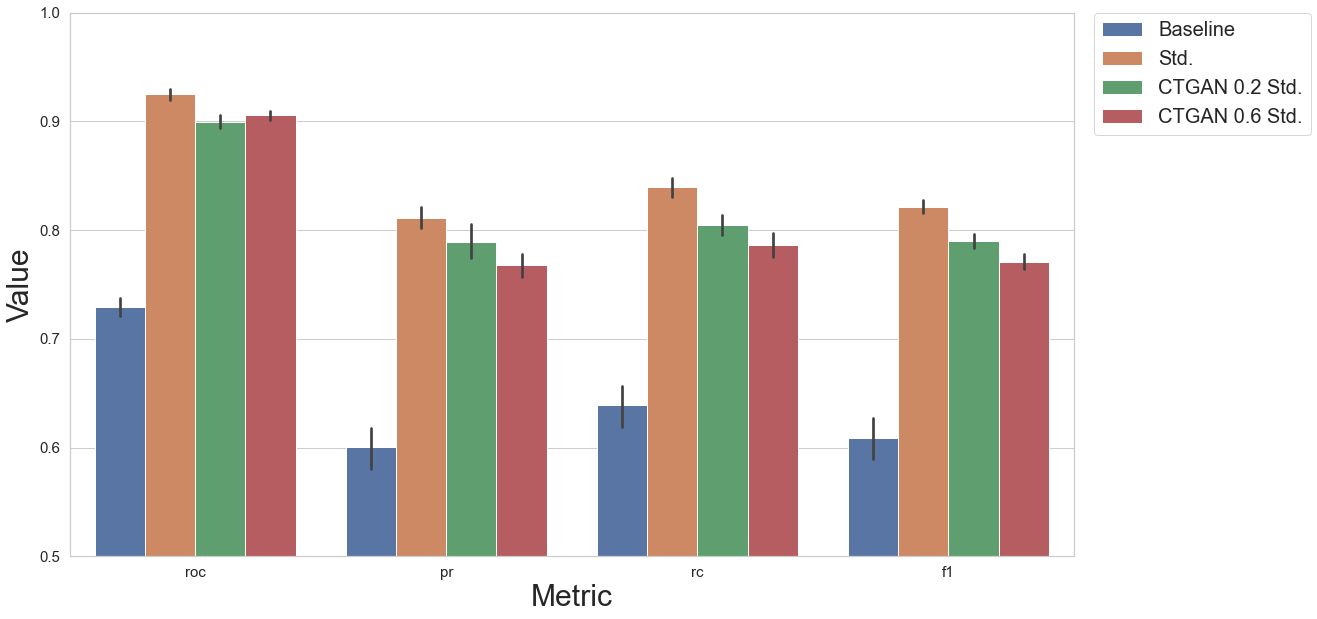

In [40]:
plot_results(result_df)

## XGBoost

In [25]:
MODEL_NAME = "xgb"

result_base = test_base(df, label_col, N_EXEC, MODEL_NAME)
result_df = add_results_df(None, result_base, "Baseline")

result_cor = test_corr(df, label_col, N_EXEC, MODEL_NAME)
result_df = add_results_df(result_df, result_cor, "Corr.")

result_tr = test_corr_transf(df, label_col, N_EXEC, dp.DataStandardScaler, MODEL_NAME, num_col)
result_df = add_results_df(result_df, result_tr, "Std.")

result_tr = test_corr_transf(df, label_col, N_EXEC, dp.DataMinMaxScaler, MODEL_NAME, num_col)
result_df = add_results_df(result_df, result_tr, "Min/Max.")

result_tr = test_corr_transf(df, label_col, N_EXEC, dp.DataQuantileTransformer, MODEL_NAME, num_col)
result_df = add_results_df(result_df, result_tr, "Quantile")

result_tr = test_corr_transf(df, label_col, N_EXEC, dp.DataNormalizer, MODEL_NAME, num_col)
result_df = add_results_df(result_df, result_tr, "Normalizer")

result_tr = test_corr_transf(df, label_col, N_EXEC, dp.DataRobustScaler, MODEL_NAME, num_col)
result_df = add_results_df(result_df, result_tr, "Robust")

result_tr = test_corr_transf(df, label_col, N_EXEC, dp.DataPowerTransformer, MODEL_NAME, num_col)
result_df = add_results_df(result_df, result_tr, "Power")

../../errorsmitigation/dataprocessing/utils_model.py:65: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


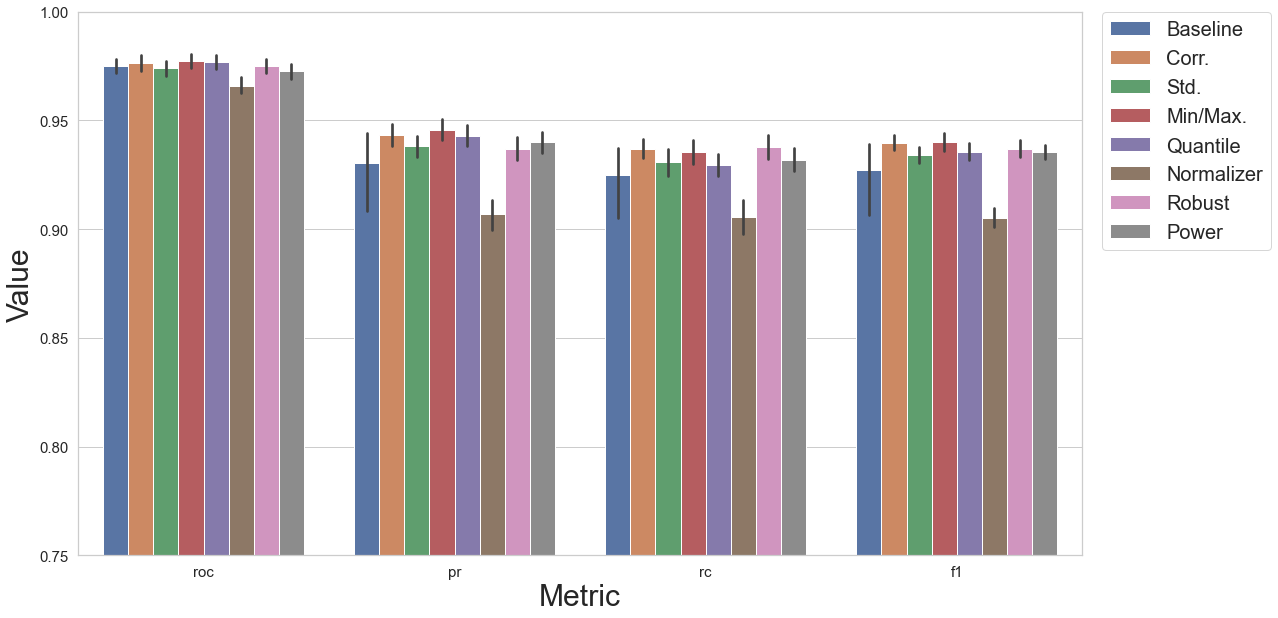

In [27]:
plot_results(result_df, y_lim=[0.75,1.0])

In [28]:
result_base = test_base(df, label_col, N_EXEC, MODEL_NAME)
result_df = add_results_df(None, result_base, "Baseline")

restult_fs = test_smote_transf(df, label_col, N_EXEC, MODEL_NAME, rcorr=True, scaler_ref=dp.DataQuantileTransformer, num_col=num_col, feat_sel_type=SEQ_BWD)
result_df = add_results_df(result_df, restult_fs, "Seq.Bwd.Qtl.")

restult_fs = test_smote_transf(df, label_col, N_EXEC, MODEL_NAME, rcorr=True, scaler_ref=dp.DataQuantileTransformer, num_col=num_col, feat_sel_type=CATBOOST)
result_df = add_results_df(result_df, restult_fs, "CatBoost Qtl.")

../../errorsmitigation/dataprocessing/utils_model.py:65: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
../../errorsmitigation/dataprocessing/utils_model.py:65: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
../../errorsmitigation/dataprocessing/utils_model.py:65: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
../../errorsmitigation/dataprocessing/utils_model.py:65: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
../../errorsmitigation/dataprocessing/utils_model.py:65: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
../../errorsmitigation/dataprocessing/utils_model.py:65: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * preci

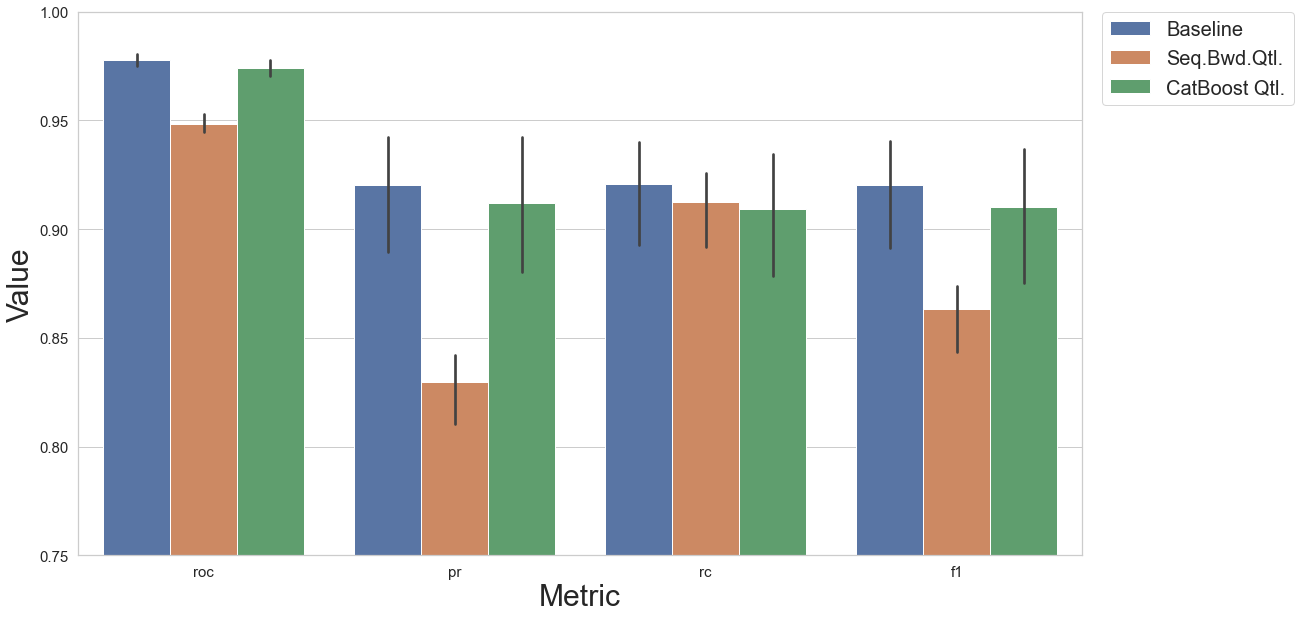

In [29]:
plot_results(result_df, y_lim=[0.75,1.0])

In [45]:
MODEL_NAME = "xgb"
result_base = test_base(df, label_col, N_EXEC, MODEL_NAME)
result_df = add_results_df(None, result_base, "Baseline")

result_tr = test_corr_transf(df, label_col, N_EXEC, dp.DataQuantileTransformer, MODEL_NAME, num_col)
result_df = add_results_df(result_df, result_tr, "Qtl.")

restult_fs = test_ctgan_first(df, label_col, N_EXEC, MODEL_NAME, rcorr=True, scaler_ref=dp.DataQuantileTransformer, num_col=num_col, feat_sel_type=None, art_str=0.2, savefile="3_3.pkl")
result_df = add_results_df(result_df, restult_fs, "CTGAN 0.2 Qtl.")

restult_fs = test_ctgan_first(df, label_col, N_EXEC, MODEL_NAME, rcorr=True, scaler_ref=dp.DataQuantileTransformer, num_col=num_col, feat_sel_type=None, art_str=0.6, savefile="3_4.pkl")
result_df = add_results_df(result_df, restult_fs, "CTGAN 0.6 Qtl.")


../../errorsmitigation/dataprocessing/utils_model.py:65: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
../../errorsmitigation/dataprocessing/utils_model.py:65: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
../../errorsmitigation/dataprocessing/utils_model.py:65: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
../../errorsmitigation/dataprocessing/utils_model.py:65: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
../../errorsmitigation/dataprocessing/utils_model.py:65: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
../../errorsmitigation/dataprocessing/utils_model.py:65: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * preci

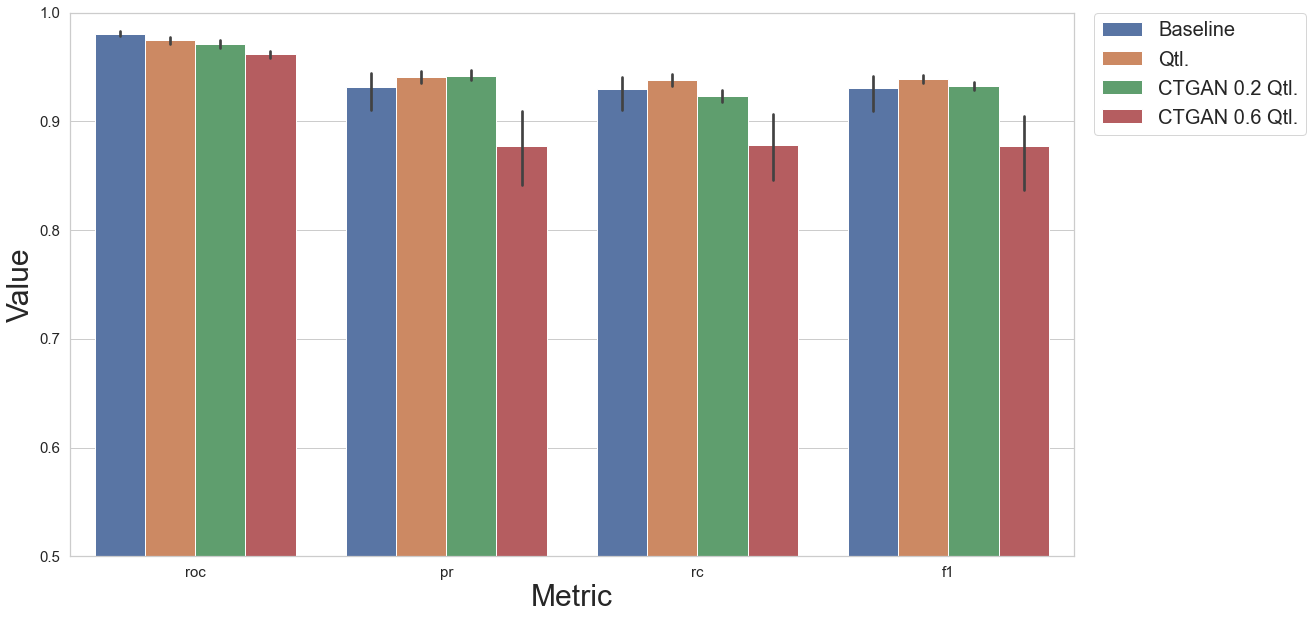

In [44]:
plot_results(result_df)